In [1]:
import json
import logging
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import interpolate

C:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Futu

In [2]:
from config import get_config
from equation import get_equation
from solver import FeedForwardModel

In [3]:
s0=100
k=100
r=0.00
sigma=0.20
T=1

d1=(np.log(s0/k)+(r+sigma*sigma/2)*T)/(sigma*np.sqrt(T))
d2=(np.log(s0/k)+(r-sigma*sigma/2)*T)/(sigma*np.sqrt(T))

print(norm.cdf(d1)*s0-norm.cdf(d2)*k*np.exp(-r*T))

7.965567455405804


In [4]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.app.flags.FLAGS)

FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string('f', '', 'kernel')

tf.app.flags.DEFINE_string('problem_name', 'EuropeanCall',
                           """The name of partial differential equation.""")
tf.app.flags.DEFINE_integer('num_run', 1,
                            """The number of experiments to repeatedly run for the same problem.""")
tf.app.flags.DEFINE_string('log_dir', './logs',
                           """Directory where to write event logs and output array.""")

In [5]:
weight_list=[]
problem_name = FLAGS.problem_name
config = get_config(problem_name)
bsde = get_equation(problem_name, config.dim, config.total_time, config.num_time_interval)

if not os.path.exists(FLAGS.log_dir):
    os.mkdir(FLAGS.log_dir)
path_prefix = os.path.join(FLAGS.log_dir, problem_name)
with open('{}_config.json'.format(path_prefix), 'w') as outfile:
    json.dump(dict((name, getattr(config, name))
                    for name in dir(config) if not name.startswith('__')),
                outfile, indent=2)
logging.basicConfig(level=logging.INFO,
                    format='%(levelname)-6s %(message)s')

for idx_run in range(1, FLAGS.num_run+1):
    tf.reset_default_graph()
    with tf.Session() as sess:
        logging.info('Begin to solve %s with run %d' % (problem_name, idx_run))
        model = FeedForwardModel(config, bsde, sess)
        if bsde.y_init:
            logging.info('Y0_true: %.4e' % bsde.y_init)
        model.build()
        training_history, graphs = model.train()
        for i in tf.trainable_variables():
            temp=i.name.split('/')
            #print(temp)
            if len(temp)>1:
                if temp[1]=='1':
                    weight_list.append(sess.run(i))
            #print(i.name)
            #print(sess.run(i))
            #print('\n')
        if bsde.y_init:
            logging.info('relative error of Y0: %s',
                            '{:.2%}'.format(
                                abs(bsde.y_init - training_history[-1, 2])/bsde.y_init))
        # save training history
        np.savetxt('{}_training_history_{}.csv'.format(path_prefix, idx_run),
                    training_history,
                    fmt=['%d', '%.5e', '%.5e', '%d'],
                    delimiter=",",
                    header="step,loss_function,target_value,elapsed_time",
                    comments='')

g=graphs

INFO   Begin to solve EuropeanCall with run 1


WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:58: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:61: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:76: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



t: 0
Instructions for updating:
keep_dims is deprecated, use keepdims instead


WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:83: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:125: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.



WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:145: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8



WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:105: The name tf.train.piecewise_constant is deprecated. Please use tf.compat.v1.train.piecewise_constant instead.



WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:110: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

INFO   step:     0,    loss: 1.7102e+02,   Y0: 1.2113e+01,  elapsed time  10
INFO   z_init: -5.7571e-03
INFO   step:   100,    loss: 1.6597e+02,   Y0: 1.1624e+01,  elapsed time  11
INFO   z_init: 1.2083e-01
INFO   step:   200,    loss: 1.6187e+02,   Y0: 1.1158e+01,  elapsed time  12
INFO   z_init: 1.3791e-01
INFO   step:   300,    loss: 1.5851e+02,   Y0: 1.0735e+01,  elapsed time  12
INFO   z_init: 1.5872e-01
INFO   step:   400,    loss: 1.5583e+02,   Y0: 1.0350e+01,  elapsed time  12
INFO   z_init: 1.4810e-01
INFO   step:   500,    loss: 1.5351e+02,   Y0: 9.9871e+00,  elapsed time  12
INFO   z_init: 1.6884e-01
INFO   step:   600,    loss: 1.5174e+02,   Y0: 9.6703e+00,  elapsed time  13
INFO   z_init: 1.6688e-01
INFO   step:   700,    loss: 1.5029e+02,   Y0: 9.3839e+00,  elapsed time  13
INFO  

In [6]:
def sigmoid(d):
    return 1/(1+np.exp(-d))

def relu(d):
    return np.maximum(d,0)

In [7]:
weight_list

[array([[-0.9637853 , -0.08140064, -0.12801078,  0.75271453,  1.36303914,
          0.15376252, -0.41426637, -2.07310416,  0.12798492,  0.11166282,
          0.07300716]]),
 array([[-7.47204679e-01,  1.06289885e+00,  1.57241649e+00,
         -1.86142643e-01, -4.10484078e-01,  3.19091684e-01,
         -2.73764701e-01,  1.49730232e+00, -1.99557390e+00,
          4.92573694e-01,  1.97399852e+00],
        [-2.85291612e-01,  5.46037882e-01,  1.31871467e+00,
          1.80458210e+00,  1.10073069e-01,  1.44991446e+00,
         -1.51113220e-01, -3.22916872e-01, -4.54821950e-01,
         -1.14935478e-01,  8.23006221e-01],
        [ 2.67702525e+00,  9.14085387e-01, -4.55701977e-01,
          1.83075142e+00, -4.63056444e-02,  4.83816537e-01,
         -9.71560853e-01, -1.03958302e+00,  6.78878031e-01,
          6.18217357e-01, -5.35432115e-01],
        [-1.81712747e+00,  1.84761392e-01,  6.31375154e-01,
         -3.42268389e-01, -5.30678670e-01, -6.34533054e-01,
          8.85155941e-01,  4.739055

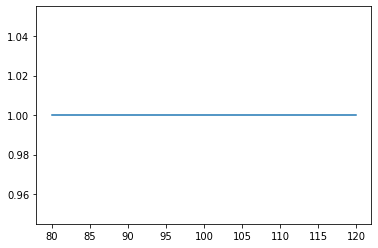

In [8]:
a=weight_list[0]
b=weight_list[1]
c=weight_list[2]
d=weight_list[3]
e=weight_list[4]

def layer(x):
    x=relu(a.dot(x).T)
    x=relu((b.T).dot(x))
    x=relu((c.T).dot(x))
    x=(d.T).dot(x)
    return sigmoid(x+e)

y=[layer(x) for x in np.linspace(80,120, 82)]
y=np.array(y).reshape(len(y),1)
fig, ax = plt.subplots()
ax.plot(np.linspace(80,120, 82),y)

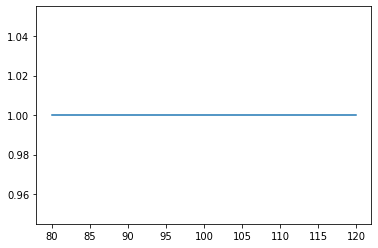

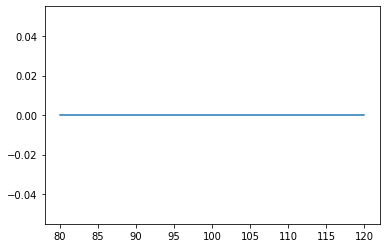

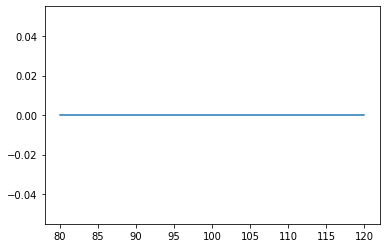

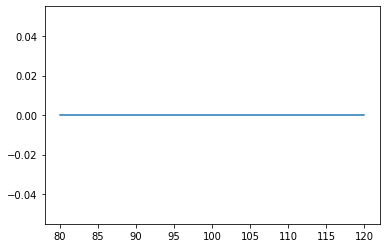

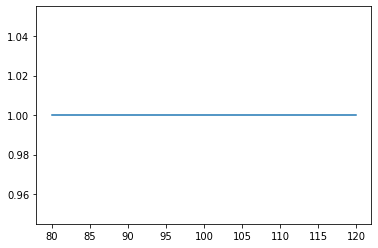

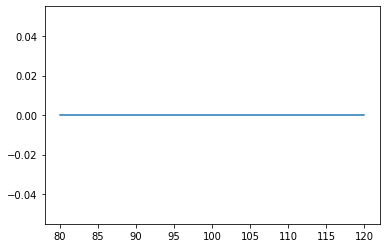

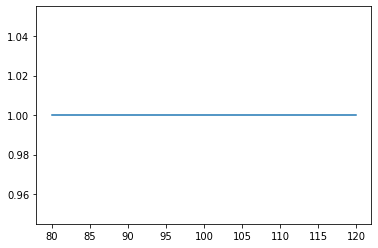

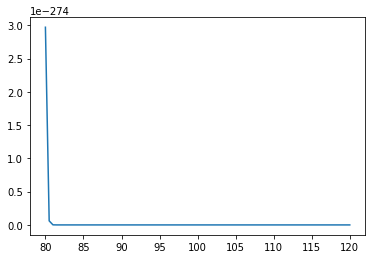

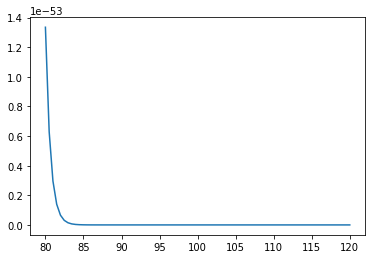

In [9]:
for i in range(len(g)):
    fig, ax = plt.subplots()
    ax.plot(np.linspace(80,120, 82),np.array(g[i]).flatten())